In [1]:
import pandas as pd
import re
import networkx as nx

>* We will use the data from week 6, which we used the feather format to store the data. We will use it to build a graph and analyze it.

In [2]:
data=pd.read_feather('../week6/sample-feather.feather')

>* Let's check the columns

In [3]:
data.columns

Index(['thread_id', 'thread_name', 'body', 'account', 'url', 'date',
       'longevity'],
      dtype='object')

>* In `data` dataframe, we have six columns, each representing as follows:
    
    * `thread_id` : unique id for each thread
    * `thread_name` : the first subject of the email
    * `body` : the content of the email 
    * `account` : the email account of the sender 
    * `url` : the url of the email
    * `date` : the date of the email 

In [4]:
data.head(5)

,thread_id,thread_name,body,account,url,date,longevity
0,5608,Tool-to-log-all-messages-targeting-a-given-window,"[Hello all, Does someone here know of a tool t...","[webmaster, jtwauthier, soronel.haetir]",[https://www.freelists.org/post/program-l/Tool...,"[2016-01-19T10:12:01.000000000, 2016-01-19T15:...",0 days 06:12:00
1,6826,html5js-newby,"[HI All, I'm trying to create a demo for aira ...","[blindwiz, taksantong, blindwiz]",[https://www.freelists.org/post/program-l/html...,"[2019-02-20T07:34:07.000000000, 2019-02-20T17:...",0 days 13:54:20
2,4209,Searching-in-dataTables-vbnet,[Hi all. A dataTable is the registers of one t...,"[pmorales, ofbgmail, pmorales, ofbgmail, pmora...",[https://www.freelists.org/post/program-l/Sear...,"[2013-09-02T23:01:35.000000000, 2013-09-03T15:...",5 days 17:13:11
3,2119,Ot-looking-for-an-app,"[Hello, I've got an assignment for management ...","[compgeek13, justind, wunderg]",[https://www.freelists.org/post/program-l/Ot-l...,"[2008-11-11T00:52:32.000000000, 2008-11-11T13:...",0 days 14:42:00
4,2906,Learn-Python-The-Hard-Way-Second-Edition,"[Hi, For those interested, Learn Python Hard W...","[james.homme, jr]",[https://www.freelists.org/post/program-l/Lear...,"[2011-12-05T12:45:48.000000000, 2011-12-05T16:...",0 days 04:05:30


> * Let's build edges between the users in the `account` column.

In [5]:
#We will need a combination of all the accounts in the 'account' column to create the edges of the graph
#We will use itertools.combinations to create the combination

import itertools
edges=[]
for idx, val in data['account'].items():
    edges.extend(list(itertools.combinations(val, 2)))

In [6]:
edges[:5]

[('webmaster', 'jtwauthier'),
 ('webmaster', 'soronel.haetir'),
 ('jtwauthier', 'soronel.haetir'),
 ('blindwiz', 'taksantong'),
 ('blindwiz', 'blindwiz')]

>* Let's get rid of the self-loops.

In [7]:
edges_loop = [edge for edge in edges if edge[0] != edge[1]]

In [8]:
edges_loop[:5]

[('webmaster', 'jtwauthier'),
 ('webmaster', 'soronel.haetir'),
 ('jtwauthier', 'soronel.haetir'),
 ('blindwiz', 'taksantong'),
 ('taksantong', 'blindwiz')]

>* We will generate an empty graph object `G` and populate the graph with the edges.

In [9]:
G=nx.Graph()

In [10]:
G.add_edges_from(edges_loop)

>* Let's put the degree centrality score as a node attribute called `degree`.
>* To do so, we use the `nx.set_node_attributes` method.

In [11]:
nx.set_node_attributes(G, nx.degree_centrality(G), 'degree')

>* Let's put the betweenness centrality score as a node attribute called `betweenness`.
>* To do so, we use the `nx.set_node_attributes` method.

In [12]:
nx.set_node_attributes(G, nx.betweenness_centrality(G), 'betweenness')

>* Let's put the closeness centrality score as a node attribute called `closeness`.
>* To do so, we use the `nx.set_node_attributes` method.

In [13]:
nx.set_node_attributes(G, nx.closeness_centrality(G), 'closeness')

>* Let's have another node attribute called `role`.
>* If the user initiated the email conversation thread, we will assign the value `asker`.
>* If the user replied to the email conversation thread, we will assign the value `answerer`.
>* No matter `asker` replied to the email conversation thread later, we will still assign the value `asker`.

In [14]:
asker=data['account'].apply(lambda x: x[0]) # find the first element in the column 'account'.

In [15]:
role={}
for val in [i for sublist in data['account'] for i in sublist]:
    if val in set(asker):
        role[val]='asker'
    else:
        role[val]='answerer'

In [16]:
nx.set_node_attributes(G, role, 'role')

>* Homophily is the tendency of individuals to associate and bond with similar others.
>* We can measure homophily by comparing the number of edges between nodes of the same type to the number of edges between nodes of different types.
>* One of popular ways to measure the node-level homophily is to calculate the E-I index proposed by Krackhardt and Stern (1988).
>* https://doi.org/10.2307/2786835

<img src="../week8/ei-index.png" width=500px height=500px />

>* Unfortunately, networkx does not have a built-in function to calculate the E-I index.
>* We will make a function to calculate the E-I index.

In [17]:
def ego_EI_idx(graph_object):
    EI_dic = {}
    for k in graph_object.nodes:
        external = 0
        internal = 0
        try:
            for i in graph_object.edges(k):
                if graph_object.nodes[i[1]]['role'] == graph_object.nodes[k]['role']:
                    internal += 1
                else:
                    external += 1
        except ZeroDivisionError:
            pass
        if external + internal != 0:
            EI_dic[k] = (external - internal) / (external + internal)
        else:
            EI_dic[k] = 0
    nx.set_node_attributes(graph_object, EI_dic, name="ei_idx")

In [18]:
ego_EI_idx(G)

In [19]:
G.nodes['webmaster']

{'degree': 0.17266187050359713,
 'betweenness': 0.028790642170402562,
 'closeness': 0.4527687296416938,
 'role': 'asker',
 'ei_idx': 0.25}

>* When drawing the graph, the location of the nodes will be determined randomly.
>* By specifying the `pos` parameter, we can set the location of the nodes.
>* First, we will have `kamada_kawai_layout` to set the location of the nodes.
>* The position of the nodes will be determined by Kamada-Kawai path-length cost-function.
>* See details here: https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.kamada_kawai_layout.html

In [20]:
pos=nx.kamada_kawai_layout(G)

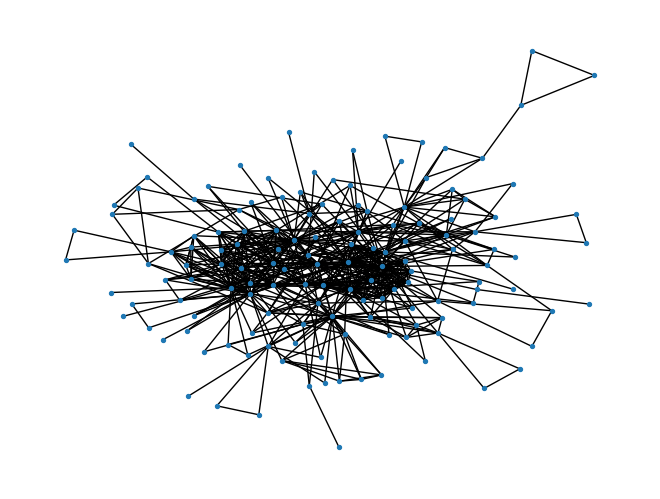

In [21]:
nx.draw(G, pos=pos, node_size=8)

>* Another layout is `spring_layout`.
>* The positions of the nodes will be determined by Fruchterman-Reingold force-directed algorithm.
>* See details here: https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html

In [22]:
pos=nx.spring_layout(G)

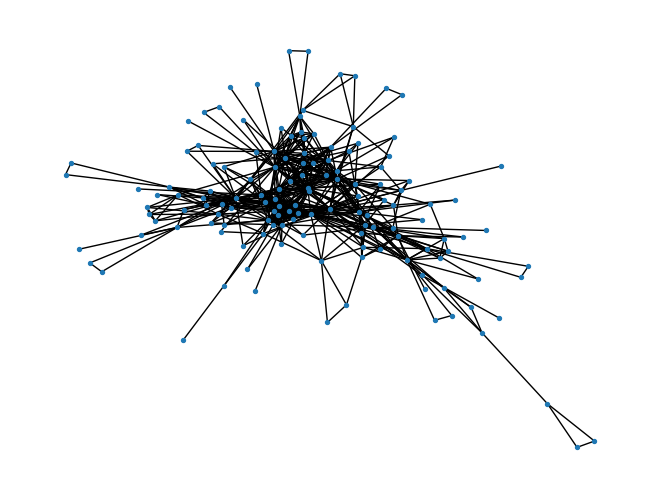

In [23]:
nx.draw(G, pos=pos, node_size=8)

>* Lastly, though it is not recommended, it is `random_layout`.
>* The positions of the nodes will be determined randomly.

In [24]:
pos=nx.random_layout(G)

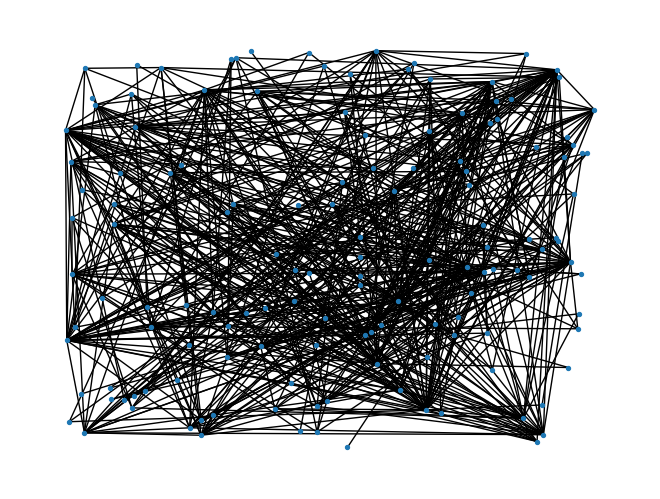

In [25]:
nx.draw(G, pos=pos, node_size=8)

>* Once we deterimine the layout, we can specify the `node size`, `node color`, and `node shape`.

>* We can change the size of nodes based on the `degree centrality`.
>* In nx.draw, we can specify the `node_size` parameter to change the size of the nodes.
>* We will use the value of `degree centrality` to decide the size of the nodes.

In [26]:
pos=nx.kamada_kawai_layout(G)

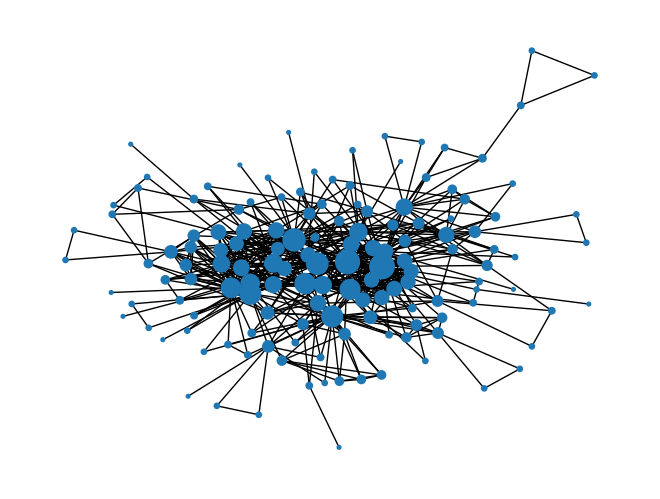

In [27]:
nx.draw(G, pos=pos, 
        node_size=[G.nodes[node]['degree']*1000 for node in G.nodes()])

>* We can also change the size of nodes based on the `ei_idx` attribute.

/Users/mstudio/miniconda3/envs/py3.10/lib/python3.10/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


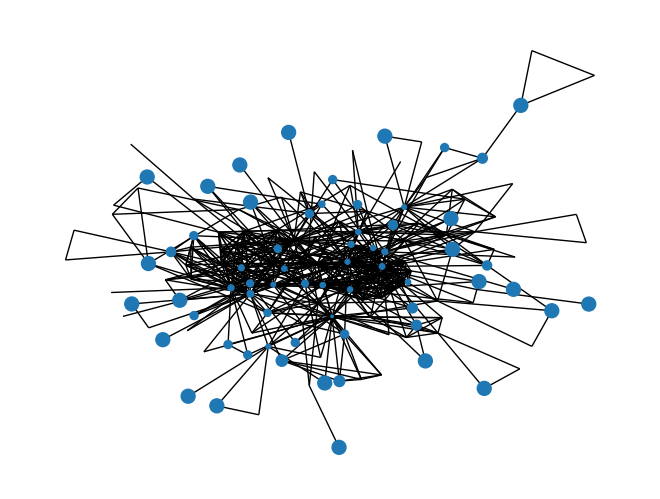

In [28]:
nx.draw(G, pos=pos, 
        node_size=[G.nodes[node]['ei_idx']*100 for node in G.nodes()])

>* We can change the color of the nodes based on the `role`.
>* In nx.draw, we can use the `node_color` parameter to specify the color of the nodes.

In [29]:
G.nodes['webmaster']

{'degree': 0.17266187050359713,
 'betweenness': 0.028790642170402562,
 'closeness': 0.4527687296416938,
 'role': 'asker',
 'ei_idx': 0.25}

>* Let's create an attribute for the nodes based on values in the `role` attribute.

In [30]:
for node in G.nodes():
    if G.nodes[node]['role'] == 'asker':
        G.nodes[node]['color'] = 'crimson'
    elif G.nodes[node]['role'] == 'answerer':
        G.nodes[node]['color'] = 'blue'

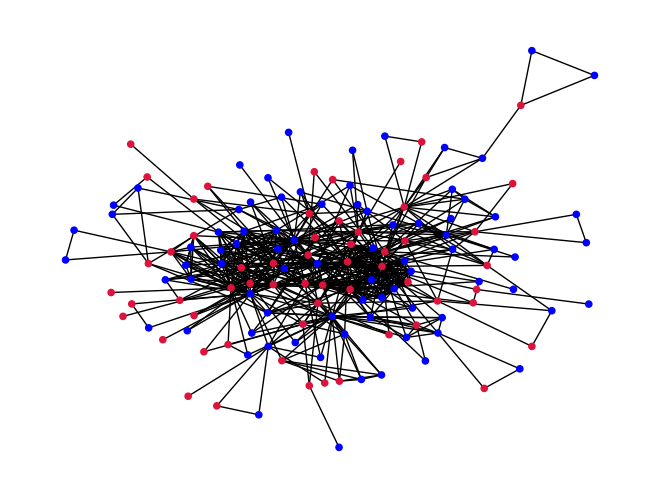

In [31]:
nx.draw(G, pos=pos, node_size=20, 
        node_color=[G.nodes[node]['color'] for node in G.nodes()])

>* In addition to the color of the nodes, we can also change the shape of the nodes based on the `role`.

In [32]:
for node in G.nodes():
    if G.nodes[node]['role']=='asker':
        G.nodes[node]['shape']='^'
    elif G.nodes[node]['role']=='answerer':
        G.nodes[node]['shape']='o'

>* Unfortunately, NetworkX does not support drawing nodes with different shapes at the same time.

ValueError: Unrecognized marker style ['^', 'o', 'o', '^', '^', '^', '^', '^', '^', '^', 'o', '^', 'o', '^', 'o', 'o', 'o', '^', 'o', '^', 'o', 'o', 'o', 'o', '^', 'o', 'o', '^', '^', 'o', 'o', '^', 'o', '^', '^', 'o', '^', 'o', 'o', 'o', 'o', '^', 'o', 'o', 'o', 'o', '^', 'o', '^', 'o', 'o', 'o', 'o', '^', '^', 'o', '^', 'o', '^', '^', 'o', 'o', '^', '^', '^', '^', 'o', '^', '^', 'o', 'o', '^', 'o', 'o', 'o', '^', 'o', 'o', '^', '^', 'o', '^', '^', 'o', 'o', 'o', '^', 'o', 'o', '^', 'o', '^', 'o', '^', 'o', '^', 'o', 'o', '^', 'o', 'o', 'o', '^', 'o', '^', 'o', '^', 'o', 'o', 'o', 'o', 'o', 'o', '^', '^', 'o', '^', '^', '^', '^', 'o', 'o', 'o', 'o', 'o', 'o', 'o', '^', 'o', 'o', '^', 'o', '^', 'o', '^', '^', 'o', 'o', 'o', 'o']

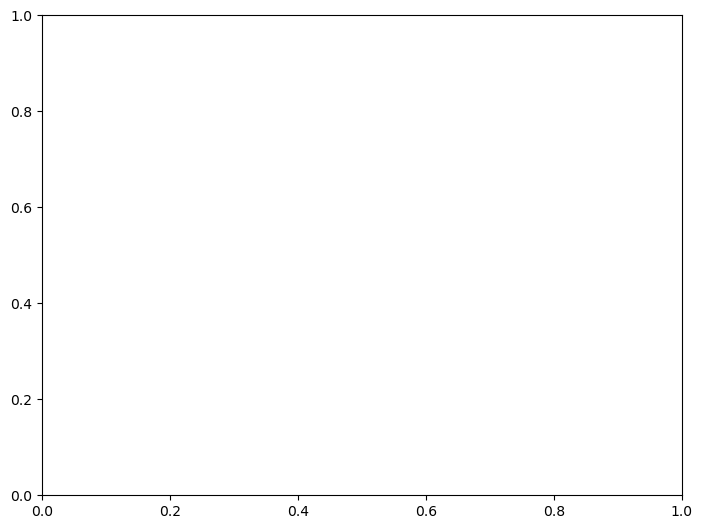

In [33]:
nx.draw(G, pos=pos, node_size=20, 
        node_color=[G.nodes[node]['color'] for node in G.nodes()],
        node_shape=[G.nodes[node]['shape'] for node in G.nodes()])

>* To avoid the error, we will need to use the `draw_networkx_nodes` function to draw the nodes with different shapes separately.

>* First, we will collect the name of the nodes and save them in different variables.

In [34]:
asker_nodes=[node for node in G.nodes() if G.nodes[node]['role']=='asker']
answerer_nodes=[node for node in G.nodes() if G.nodes[node]['role']=='answerer']

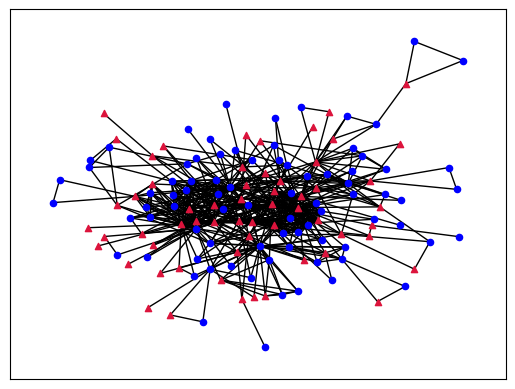

In [35]:
nx.draw_networkx_nodes(G, pos=pos, nodelist=asker_nodes, 
                       node_size=20, 
                       node_color='crimson',
                       node_shape='^')
nx.draw_networkx_nodes(G, pos=pos,
                       nodelist=answerer_nodes, 
                       node_size=20, 
                       node_color='blue',
                       node_shape='o')
nx.draw_networkx_edges(G, pos=pos)

>* You can put the `node size`, `node color`, and `node shape` parameters in the `draw_networkx_nodes` function at the same time.

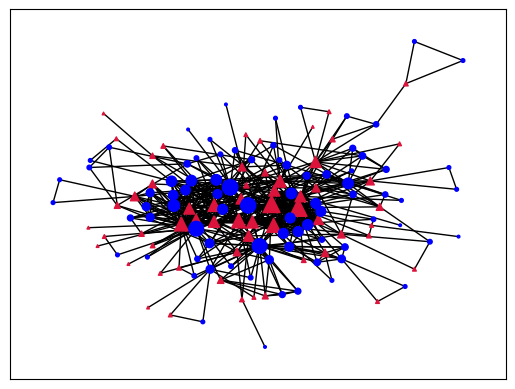

In [36]:
nx.draw_networkx_nodes(G, pos=pos, nodelist=asker_nodes,
    node_size=[G.nodes[node]['degree']*500 for node in asker_nodes], 
                       node_color='crimson',
                       node_shape='^')
nx.draw_networkx_nodes(G, pos=pos, nodelist=answerer_nodes,
    node_size=[G.nodes[node]['degree']*500 for node in answerer_nodes], 
                        node_color='blue',
                        node_shape='o')
nx.draw_networkx_edges(G, pos=pos)

>* Let's label the nodes with the `account` attribute.

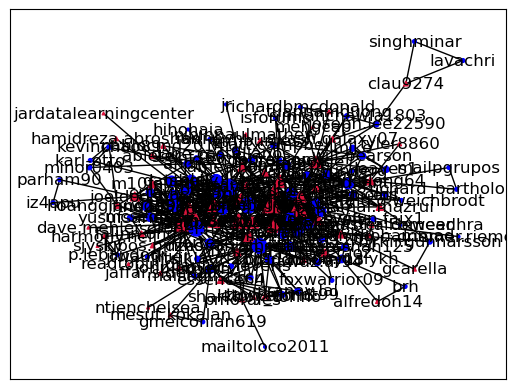

In [37]:
nx.draw_networkx_nodes(G, pos=pos, nodelist=asker_nodes,
    node_size=[G.nodes[node]['degree']*500 for node in asker_nodes], 
                       node_color='crimson',
                       node_shape='^')
nx.draw_networkx_nodes(G, pos=pos, nodelist=answerer_nodes,
    node_size=[G.nodes[node]['degree']*500 for node in answerer_nodes], 
                        node_color='blue',
                        node_shape='o')
nx.draw_networkx_labels(G, pos=pos, 
                        labels={node:node for node in G.nodes()})
nx.draw_networkx_edges(G, pos=pos)

>* Labeling all the nodes can overlap the labels, so we will label only the nodes with the `degree centrality` greater than 0.1.

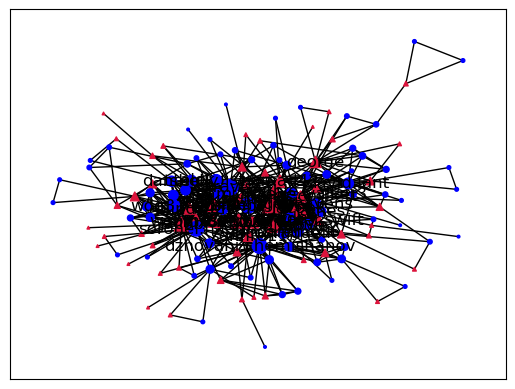

In [38]:
nx.draw_networkx_nodes(G, pos=pos, nodelist=asker_nodes,
    node_size=[G.nodes[node]['degree']*500 for node in asker_nodes], 
                       node_color='crimson',
                       node_shape='^')
nx.draw_networkx_nodes(G, pos=pos, nodelist=answerer_nodes,
    node_size=[G.nodes[node]['degree']*500 for node in answerer_nodes], 
                        node_color='blue',
                        node_shape='o')
nx.draw_networkx_labels(G, pos=pos,
                        labels={node:node for node in G.nodes() if G.nodes[node]['degree'] > 0.1})
nx.draw_networkx_edges(G, pos=pos)

>* Labeling all the nodes can overlap the labels, so we will label only the nodes with the `degree centrality` lower than 0.1.

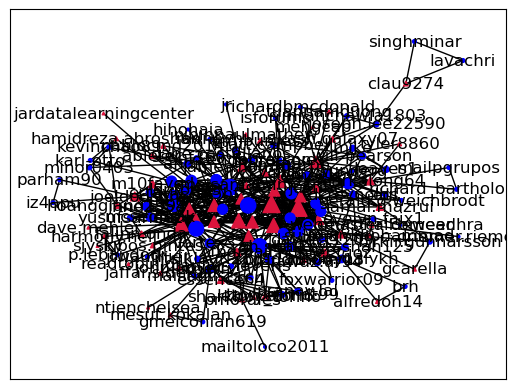

In [40]:
nx.draw_networkx_nodes(G, pos=pos, nodelist=asker_nodes,
    node_size=[G.nodes[node]['degree']*500 for node in asker_nodes], 
                       node_color='crimson',
                       node_shape='^')
nx.draw_networkx_nodes(G, pos=pos, nodelist=answerer_nodes,
    node_size=[G.nodes[node]['degree']*500 for node in answerer_nodes], 
                        node_color='blue',
                        node_shape='o')
nx.draw_networkx_labels(G, pos=pos,
                        labels={node:node for node in G.nodes() if G.nodes[node]['degree'] < 0.1})
nx.draw_networkx_edges(G, pos=pos)